# Import libraries

In [1]:
!pip install nltk

In [2]:
!pip install xgboost

In [235]:
import pandas as pd
import numpy as np
import re

import os
import tarfile
import urllib

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet, words
from nltk.stem import WordNetLemmatizer 

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from tqdm.auto import tqdm

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/jupyter/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Downloading data

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O data.tar.gz

In [ ]:
# Unzipping the data files.
tar = tarfile.open('data.tar.gz', 'r:gz')
tar.extractall()
tar.close()

# Full data Loading & Cleaning

In [104]:
def collect_data(data_path: str) -> [str]:
    """
       Reading files form a given directory path
       
       Arguments:
           data_path: string holding the path from which you want to read files.
        Return:
            list contains the contents of all the files with in the directory path.
    """
    reviews = []
    for review_file in os.listdir(data_path):
        review_file = os.path.join(data_path, review_file)
        with open(review_file, 'r') as review:
            reviews.append(review.read().rstrip())
    return reviews  

In [105]:
def clean(data: [str]) -> [str]:
    """
        Performing basic clean for the contents of the file.
        Removs all numbers and punctuations from the string and replace a space instead.
        
        Arguments:
            data: list of strings need to be cleaned.
        Return:
            list of cleaned strings.
    """
    cleaned_data = []
    for item in data:
        item = item.lower()
        item = re.sub(r'[^\w\s]|[\d+]', '', item)
        cleaned_data.append(item)
    return cleaned_data 

In [106]:
# Preparing the stopwards in English
english_stopwords = stopwords.words('english')
# Lemmatization
lemmatizer = WordNetLemmatizer()
# Error and spelling. corrections
words = set(nltk.corpus.words.words())

In [107]:
def get_wordnet_pos(word: str) -> str:
    """
        Get the position of word i.e. dermines if the given word is Noun, Verb, Adverb or Adjective
        
        Arguments:
            word: the word for which we want to determine it type.
        Return:
            the type of the passed word
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [108]:
def advanced_clean(data: [str]):
    """
        Performing advanced clean for the contents of the passed list.
        Removing all non English words, Lemmatize each word i.e. retuen each word in each sentance to its origin.
        Updates the list place not allocating another list. O(1)
    
        Arguments:
            data: list of sentances.
        Return:
            None
    """
    for idx, sample in enumerate(data):
        __tokens__ = []
        tokens = word_tokenize(sample)
        for token in tokens:
            if token not in english_stopwords:
                token_pos = get_wordnet_pos(token) # parts of statement
                lemma = lemmatizer.lemmatize(token, token_pos)
                if  lemma in words and lemma not in english_stopwords:
                    __tokens__.append(lemma)
        data[idx] = ''.join(__token__ + ' ' for __token__ in __tokens__)

# Dummy Splitting

In [109]:
# Reading the files from the training and testing directories.

pos_training_data_path = './aclImdb/train/pos'
neg_training_data_path = './aclImdb/train/neg'
pos_testing_data_path = './aclImdb/test/pos'
neg_testing_data_path = './aclImdb/test/neg'

train_pos_reviews = collect_data(pos_training_data_path)
train_neg_reviews = collect_data(neg_training_data_path)
test_pos_reviews = collect_data(pos_testing_data_path)
test_neg_reviews = collect_data(neg_testing_data_path)

cleaned_train_pos_reviews = clean(train_pos_reviews)
cleaned_train_neg_reviews = clean(train_neg_reviews)
cleaned_test_pos_reviews = clean(test_pos_reviews)
cleaned_test_neg_reviews = clean(test_neg_reviews)
  
print('Number of positive reviews: {}, and the number of negative reviews is: {}'.format(len(train_pos_reviews), len(train_neg_reviews)))
print('Number of positive reviews: {}, and the number of negative reviews is: {}'.format(len(test_pos_reviews), len(test_neg_reviews)))

In [ ]:
advanced_clean(cleaned_train_pos_reviews)
advanced_clean(cleaned_train_neg_reviews)
advanced_clean(cleaned_test_pos_reviews)
advanced_clean(cleaned_test_neg_reviews)

# Saving the data for future use
This section used to save the already cleaned data for future usage.

In [ ]:
with open('cleaned_train_pos_reviews.txt', 'w') as train_pos:
    for review in cleaned_train_pos_reviews:
      train_pos.write(review + '\n')

In [ ]:
with open('cleaned_train_neg_reviews.txt', 'w') as train_neg:
    for review in cleaned_train_neg_reviews:
      train_neg.write(review + '\n')

In [ ]:
with open('cleaned_test_pos_reviews.txt', 'w') as test_pos:
    for review in cleaned_test_pos_reviews:
      test_pos.write(review + '\n')

In [ ]:
with open('cleaned_test_neg_reviews.txt', 'w') as test_neg:
    for review in cleaned_test_neg_reviews:
      test_neg.write(review + '\n')

# Loading the data when needed
Loading the aleady saved cleaned data from saved by the above section

In [163]:
with open('cleaned_train_pos_reviews.txt', 'r') as train_pos:
    temp = train_pos.read()
full_train = temp.split('\n')[:-1]

In [164]:
with open('cleaned_train_neg_reviews.txt', 'r') as train_neg:
    temp = train_neg.read()
full_train = full_train + temp.split('\n')[:-1]

In [165]:
with open('cleaned_test_pos_reviews.txt', 'r') as test_pos:
    temp = test_pos.read()
test = temp.split('\n')[:-1]

In [166]:
with open('cleaned_test_neg_reviews.txt', 'r') as test_neg:
    temp = test_neg.read()
test = test + temp.split('\n')[:-1]

# Splitting to Train, Validation

In [167]:
# Creating the labels of the train and test data in the same order they are loaded from the directories 

MAX_ITER = 12500
y_full_train = [1 for i in range(MAX_ITER)] + [0 for i in range(MAX_ITER)]
y_test = [1 for i in range(MAX_ITER)] + [0 for i in range(MAX_ITER)]

In [168]:
# Splitting the full_train_data (all the loaded data from the train directory) to train, validation 90%, 10% respectively 

X_train, X_validation, y_train, y_validation = train_test_split(full_train, y_full_train, test_size=0.1,  shuffle=True, random_state=17)

In [169]:
print(f'Train: {len(X_train)}, Validation: {len(X_validation)}, y_train: {len(y_train)}, y_validation: {len(y_validation)}')

Train: 22500, Validation: 2500, y_train: 22500, y_validation: 2500


# BoW
This is the bag of wards vectorization model.

We create constrains on the number of features created by the vectorizer.

In [170]:
cv = CountVectorizer(max_df=0.99, min_df=0.0009)
X_train_bow = cv.fit_transform(X_train)

In [171]:
X_validation_bow = cv.transform(X_validation)

In [172]:
cv.vocabulary_

{'first': 2366,
 'saw': 5311,
 'preview': 4667,
 'movie': 3972,
 'really': 4914,
 'wait': 6726,
 'see': 5376,
 'plot': 4526,
 'seem': 5380,
 'good': 2653,
 'set': 5430,
 'great': 2706,
 'mean': 3759,
 'slasher': 5609,
 'take': 6117,
 'place': 4496,
 'night': 4081,
 'idea': 3042,
 'high': 2903,
 'school': 5333,
 'teacher': 6147,
 'becomes': 537,
 'sexually': 5446,
 'obsess': 4160,
 'one': 4200,
 'student': 5949,
 'go': 2640,
 'crazy': 1396,
 'get': 2601,
 'arrest': 331,
 'escape': 2098,
 'three': 6243,
 'year': 6934,
 'later': 3463,
 'suppose': 6043,
 'happy': 2811,
 'memorable': 3790,
 'turn': 6435,
 'hell': 2873,
 'however': 3000,
 'extremely': 2229,
 'disappointed': 1725,
 'bad': 460,
 'horror': 2984,
 'ever': 2122,
 'general': 2584,
 'wasnt': 6759,
 'even': 2118,
 'scary': 5323,
 'moment': 3915,
 'seat': 5362,
 'also': 196,
 'murder': 3984,
 'scene': 5326,
 'cheesy': 986,
 'dull': 1901,
 'either': 1965,
 'stab': 5818,
 'victim': 6663,
 'stomach': 5895,
 'multiple': 3978,
 'time': 62

In [173]:
len(cv.vocabulary_)

6956

In [174]:
X_train_bow.shape

(22500, 6956)

In [175]:
cv_full = CountVectorizer(max_df=0.99, min_df=0.0009)
X_full_train_bow = cv_full.fit_transform(full_train)

In [176]:
X_test_bow = cv_full.transform(test)

In [177]:
len(cv_full.vocabulary_)

7001

# Tf_Idf
This is the TF-IDF vectorization model.

We create constrains on the number of features created by the vectorizer.

In [178]:
tf = TfidfVectorizer(max_df=0.99, min_df=0.0009, lowercase=False)
X_train_tf = tf.fit_transform(X_train)

In [179]:
X_validation_tf = tf.transform(X_validation)

In [180]:
tf.vocabulary_

{'first': 2366,
 'saw': 5311,
 'preview': 4667,
 'movie': 3972,
 'really': 4914,
 'wait': 6726,
 'see': 5376,
 'plot': 4526,
 'seem': 5380,
 'good': 2653,
 'set': 5430,
 'great': 2706,
 'mean': 3759,
 'slasher': 5609,
 'take': 6117,
 'place': 4496,
 'night': 4081,
 'idea': 3042,
 'high': 2903,
 'school': 5333,
 'teacher': 6147,
 'becomes': 537,
 'sexually': 5446,
 'obsess': 4160,
 'one': 4200,
 'student': 5949,
 'go': 2640,
 'crazy': 1396,
 'get': 2601,
 'arrest': 331,
 'escape': 2098,
 'three': 6243,
 'year': 6934,
 'later': 3463,
 'suppose': 6043,
 'happy': 2811,
 'memorable': 3790,
 'turn': 6435,
 'hell': 2873,
 'however': 3000,
 'extremely': 2229,
 'disappointed': 1725,
 'bad': 460,
 'horror': 2984,
 'ever': 2122,
 'general': 2584,
 'wasnt': 6759,
 'even': 2118,
 'scary': 5323,
 'moment': 3915,
 'seat': 5362,
 'also': 196,
 'murder': 3984,
 'scene': 5326,
 'cheesy': 986,
 'dull': 1901,
 'either': 1965,
 'stab': 5818,
 'victim': 6663,
 'stomach': 5895,
 'multiple': 3978,
 'time': 62

In [181]:
len(tf.vocabulary_)

6956

In [182]:
X_train_tf.shape

(22500, 6956)

In [183]:
tf_full = TfidfVectorizer(max_df=0.99, min_df=0.0009)
X_full_train_tf = tf_full.fit_transform(full_train)

In [184]:
X_test_tf = tf_full.transform(test)

In [185]:
len(tf_full.vocabulary_)

7001

# Word Embedding using FastText

## Word embedding with fasttext builtin testing

In [ ]:
train_ftwe = []
for i in range (len(X_train)):
  if y_train[i] == 1:
    train_ftwe.append("__label__positive "+X_train[i])
  else :
    train_ftwe.append("__label__negative "+X_train[i])
with open('train_ftwe.txt', 'w') as train:
  for review in train_ftwe:
    train.write(review + '\n')

In [ ]:
validation_ftwe = []
for i in range (len(X_validation)):
  if y_validation[i] == 1:
    validation_ftwe.append("__label__positive "+X_validation[i])
  else :
    validation_ftwe.append("__label__negative "+X_validation[i])
with open('validation_ftwe.txt', 'w') as validation:
  for review in validation_ftwe:
    validation.write(review + '\n')

In [ ]:
test_ftwe = []
for i in range (len(test)):
  if y_test[i] == 1:
    test_ftwe.append("__label__positive "+test[i])
  else :
    test_ftwe.append("__label__negative "+test[i])
with open('test_ftwe.txt', 'w') as test:
  for review in test_ftwe:
    test.write(review + '\n')

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip

In [ ]:
!unzip v0.9.2.zip

In [ ]:
cd fastText-0.9.2

In [ ]:
!pip install .

In [ ]:
ftwe_model = fasttext.train_supervised(input="/content/train_ftwe.txt", epoch =5, lr=0.1, wordNgrams=2)

In [ ]:
ftwe_model.test("/content/validation_ftwe.txt")

In [ ]:
ftwe_model.test("/content/test_ftwe.txt")

## Word embedding for classification

In [ ]:
ftwe = FastText(size=300, window=10, min_count=5, sample = 0.001)
X_train_tokenized = []
for i in range (len(X_train)):
  X_train_tokenized.append(word_tokenize(X_train[i]))

ftwe.build_vocab(sentences = X_train_tokenized)
ftwe.train(sentences = X_train_tokenized, total_examples=len(X_train_tokenized), epochs = 10)

In [ ]:
len(ftwe.wv.vocab)

In [ ]:
X_train_ftwe = np.zeros((len(X_train_tokenized), 300))
for i,s in enumerate(X_train_tokenized):
  for w in s:
    try:
      vec = ftwe[w]
    except KeyError:
      continue
    X_train_ftwe[i,:] = X_train_ftwe[i,:] + vec
  X_train_ftwe[i,:] = X_train_ftwe[i,:] / len(s)

In [ ]:
X_validation_tokenized = []
for i in range (len(X_validation)):
  X_validation_tokenized.append(word_tokenize(X_validation[i]))

X_validation_ftwe = np.zeros((len(X_validation_tokenized), 300))
for i,s in enumerate(X_validation_tokenized):
  for w in s:
    try:
      vec = ftwe[w]
    except KeyError:
      continue
    X_validation_ftwe[i,:] = X_validation_ftwe[i,:] + vec
  X_validation_ftwe[i,:] = X_validation_ftwe[i,:] / len(s)

In [ ]:
X_test_tokenized = []
for i in range (len(test)):
  X_test_tokenized.append(word_tokenize(test[i]))

X_test_ftwe = np.zeros((len(X_test_tokenized), 300))
for i,s in enumerate(X_test_tokenized):
  for w in s:
    try:
      vec = ftwe[w]
    except KeyError:
      continue
    X_test_ftwe[i,:] = X_test_ftwe[i,:] + vec
  X_test_ftwe[i,:] = X_test_ftwe[i,:] / len(s)

## Parameter Tunning

In [ ]:
for i in range (1,51):
  ftwe_model = fasttext.train_supervised(input="/content/train_ftwe.txt", epoch =i)
  print(i, ftwe_model.test("/content/validation_ftwe.txt"), ftwe_model.test("/content/test_ftwe.txt"))

In [ ]:
for i in range (1,11):
  ftwe_model = fasttext.train_supervised(input="/content/train_ftwe.txt", lr=i/10)
  print(i, ftwe_model.test("/content/validation_ftwe.txt"), ftwe_model.test("/content/test_ftwe.txt"))

In [ ]:
for i in range (1,6):
  ftwe_model = fasttext.train_supervised(input="/content/train_ftwe.txt", wordNgrams=i)
  print(i, ftwe_model.test("/content/validation_ftwe.txt"), ftwe_model.test("/content/test_ftwe.txt"))

# Training

> # KNN

>># A quick prototype

In [233]:
def KNN_proto(train, y_train, validation, y_validation):
    KNN_classifier = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
    KNN_classifier.fit(train, y_train)
    y_predicted_train = KNN_classifier.predict_proba(train)[:,1]
    y_predicted_validate = KNN_classifier.predict_proba(validation)[:,1]
    train_acc = accuracy_score(y_train, (y_predicted_train >= 0.5))
    validation_acc = accuracy_score(y_validation, (y_predicted_validate >= 0.5))
    return {'train_acc': train_acc, 'test_acc': validation_acc}

In [187]:
KNN_proto(X_train_bow, y_train, X_validation_bow, y_validation)

{'train': 0.8161333333333334, 'validation': 0.6348}

In [188]:
KNN_proto(X_train_tf, y_train, X_validation_tf, y_validation)

{'train': 0.8680444444444444, 'validation': 0.7548}

##### The previous prototype gives a really bad overfitting

>> # Parameter Tunning

>>> # n_neighbours

In [30]:
para_tunning = {
    'n_neighbors': [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)],
    'p': [1, 2, 3, 4, 5]
}

In [30]:
# tunning number of neighbours

def optmizer(train, y_train, validation, y_validation):
    accuracy_n_neighbor_based = []
    for n_neighbor in tqdm(para_tunning['n_neighbors']):
        KNN_classifier = KNeighborsClassifier(n_neighbors=n_neighbor)
        KNN_classifier.fit(train, y_train)
        y_predicted_train = KNN_classifier.predict_proba(train)[:,1]
        y_predicted_validate = KNN_classifier.predict_proba(validation)[:,1]
        train_acc = accuracy_score(y_train, (y_predicted_train >= 0.5))
        validation_acc = accuracy_score(y_validation, (y_predicted_validate >= 0.5))
        accuracy_n_neighbor_based.append((train_acc, validation_acc))
    return accuracy_n_neighbor_based

In [31]:
knn_bow_optmizer = optmizer(X_train_bow, y_train, X_validation_bow, y_validation)

  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
bow_data = {
    'n_neighbours': para_tunning['n_neighbors'],
    'train_acc': [train_acc[0] for train_acc in knn_bow_optmizer],
    'validation_acc': [train_acc[1] for train_acc in knn_bow_optmizer]
}
bow_optization_n_neighbour_based = pd.DataFrame(bow_data)
bow_optization_n_neighbour_based

,n_neighbours,train_acc,validation_acc
0,100,0.680444,0.6724
1,105,0.683867,0.6768
2,110,0.676711,0.6696
3,115,0.679244,0.6740
4,121,0.676933,0.6672
5,126,0.670089,0.6620
6,131,0.673511,0.6692
7,136,0.666400,0.6580
8,142,0.663600,0.6600
9,147,0.666889,0.6596


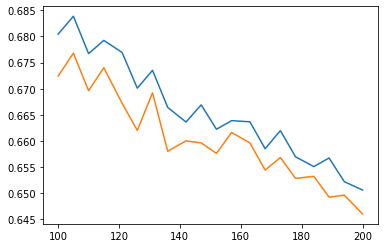

In [33]:
plt.plot(bow_optization_n_neighbour_based.n_neighbours, bow_optization_n_neighbour_based.train_acc)
plt.plot(bow_optization_n_neighbour_based.n_neighbours, bow_optization_n_neighbour_based.validation_acc)

In [34]:
knn_tf_optmizer = optmizer(X_train_tf, y_train, X_validation_tf, y_validation)

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
tf_data = {
    'n_neighbours': para_tunning['n_neighbors'],
    'train_acc': [acc[0] for acc in knn_tf_optmizer],
    'validation_acc': [acc[1] for acc in knn_tf_optmizer]
}
tf_optization_n_neighbour_based = pd.DataFrame(tf_data)
tf_optization_n_neighbour_based

,n_neighbours,train_acc,validation_acc
0,100,0.818356,0.8124
1,105,0.819467,0.8108
2,110,0.820133,0.8156
3,115,0.820667,0.8148
4,121,0.819778,0.8136
5,126,0.820133,0.8144
6,131,0.820000,0.8136
7,136,0.820311,0.8148
8,142,0.820756,0.8156
9,147,0.821022,0.8132


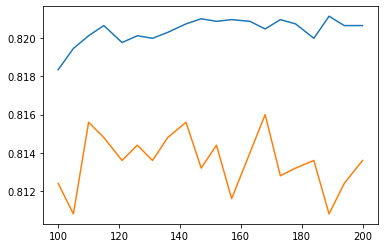

In [36]:
plt.plot(tf_optization_n_neighbour_based.n_neighbours, tf_optization_n_neighbour_based.train_acc)
plt.plot(tf_optization_n_neighbour_based.n_neighbours, tf_optization_n_neighbour_based.validation_acc)

In [37]:
# Summery

best3_bow_based_n_neighbors = bow_optization_n_neighbour_based.sort_values(by=['train_acc', 'validation_acc'], ascending=False)[:3].reset_index(drop=True)
best3_tf_based_n_neighbors = tf_optization_n_neighbour_based.sort_values(by=['train_acc', 'validation_acc'], ascending=False)[:3].reset_index(drop=True)
display(best3_bow_based_n_neighbors)
display(best3_tf_based_n_neighbors)

,n_neighbours,train_acc,validation_acc
0,105,0.683867,0.6768
1,100,0.680444,0.6724
2,115,0.679244,0.6740


,n_neighbours,train_acc,validation_acc
0,189,0.821156,0.8108
1,147,0.821022,0.8132
2,173,0.820978,0.8128


##### No optmization at all, really bad model ?
> No, It's actually the curse of dimentionality, we have 713 features which is too large for using a distance based ML algorithm.

>> # Fitting with tuned hyperparameters

In [135]:
def KNN_final(train, y_train, validation, y_validation, n_neigh):
    KNN_classifier = KNeighborsClassifier(n_neighbors=n_neigh, algorithm='auto')
    KNN_classifier.fit(train, y_train)
    y_predicted_train = KNN_classifier.predict_proba(train)[:,1]
    y_predicted_validate = KNN_classifier.predict_proba(validation)[:,1]
    train_acc = accuracy_score(y_train, (y_predicted_train >= 0.5))
    validation_acc = accuracy_score(y_validation, (y_predicted_validate >= 0.5))
    return {'train': train_acc, 'validation': validation_acc}

In [133]:
KNN_final(X_full_train_bow, y_full_train, X_test_bow, y_test, 105)

{'train': 0.66824, 'validation': 0.65836}

In [134]:
KNN_final(X_full_train_tf, y_full_train, X_test_tf, y_test, 189)

{'train': 0.77712, 'validation': 0.74704}

> # Naive Bayes

>># A quick prototype

In [232]:
def Naive_proto(train, y_train, validation, y_validation):
    Naive_classifier = MultinomialNB()
    Naive_classifier.fit(train, y_train)
    y_predicted_train = Naive_classifier.predict_proba(train)[:,1]
    y_predicted_validate = Naive_classifier.predict_proba(validation)[:,1]
    train_acc = accuracy_score(y_train, (y_predicted_train >= 0.5))
    validation_acc = accuracy_score(y_validation, (y_predicted_validate >= 0.5))
    return {'train_acc': train_acc, 'test_acc': validation_acc}

In [190]:
Naive_proto(X_train_bow, y_train, X_validation_bow, y_validation)

{'train': 0.8624, 'validation': 0.8552}

In [191]:
Naive_proto(X_train_tf, y_train, X_validation_tf, y_validation)

{'train': 0.8732444444444445, 'validation': 0.8672}

>> The splitting nature of the data cause this underfitting, the training data is large for a simple classifier such as naive bayes.

>> # Parameter Tunning

In [30]:
var_smoothing = np.logspace(0,-9, num=100)

In [31]:
def Naive_optmizer(train, y_train, validation, y_validation):
    accuracies = []
    for alpha in var_smoothing:
        Bayesian_classifier = MultinomialNB(alpha=alpha)
        Bayesian_classifier.fit(train, y_train)
        y_predicted_BoW_train_tunning = Bayesian_classifier.predict_proba(train)[:, 1]
        y_predicted_BoW_validate_tunning = Bayesian_classifier.predict_proba(validation)[:,1]
        train_acc = accuracy_score(y_train, (y_predicted_BoW_train_tunning >= 0.5))
        validation_acc = accuracy_score(y_validation, (y_predicted_BoW_validate_tunning >= 0.5))
        accuracies.append((alpha, train_acc, validation_acc))
    return accuracies

In [32]:
Naive_bow_optmizer = Naive_optmizer(X_train_bow, y_train, X_validation_bow, y_validation)

In [33]:
Naive_bow_optmization_hp = pd.DataFrame(data=Naive_bow_optmizer, columns=['alpha', 'train_acc', 'validation_acc'])
Naive_bow_optmization_hp.sort_values(by=['train_acc', 'validation_acc'])[:3]

,alpha,train_acc,validation_acc
1,0.811131,0.862222,0.8560
2,0.657933,0.862311,0.8572
0,1.000000,0.862400,0.8552


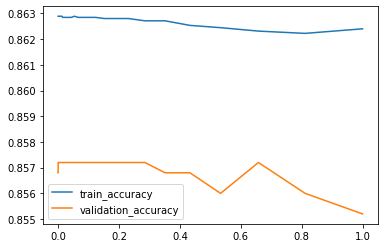

In [34]:
plt.plot(Naive_bow_optmization_hp.alpha, Naive_bow_optmization_hp.train_acc, label='train_accuracy')
plt.plot(Naive_bow_optmization_hp.alpha, Naive_bow_optmization_hp.validation_acc, label='validation_accuracy')
plt.legend();

In [35]:
Naive_tf_optmizer = Naive_optmizer(X_train_tf, y_train, X_validation_tf, y_validation)

In [36]:
Naive_tf_optmization_hp = pd.DataFrame(data=Naive_tf_optmizer, columns=['alpha', 'train_acc', 'validation_acc'])
Naive_tf_optmization_hp.sort_values(by=['train_acc', 'validation_acc'])[:3]

,alpha,train_acc,validation_acc
0,1.000000,0.873244,0.8672
1,0.811131,0.873911,0.8664
7,0.231013,0.873956,0.8628


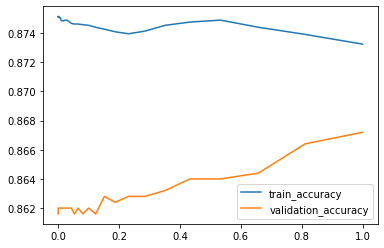

In [37]:
plt.plot(Naive_tf_optmization_hp.alpha, Naive_tf_optmization_hp.train_acc, label='train_accuracy')
plt.plot(Naive_tf_optmization_hp.alpha, Naive_tf_optmization_hp.validation_acc, label='validation_accuracy')
plt.legend();

>> # Fitting with tuned hyperparameters

In [38]:
best_para_bow = Naive_bow_optmization_hp['alpha'][0]
best_para_tf = Naive_tf_optmization_hp['alpha'][0]

In [39]:
def Naive_final(train, y_train, test, y_test, alpha=0.0):
    Naive_classifier = MultinomialNB(alpha=alpha)
    Naive_classifier.fit(train, y_train)
    y_predicted_train = Naive_classifier.predict_proba(train)[:,1]
    y_predicted_test = Naive_classifier.predict_proba(test)[:,1]
    train_acc = accuracy_score(y_train, (y_predicted_train >= 0.5))
    test_acc = accuracy_score(y_test, (y_predicted_test >= 0.5))
    return {'train': train_acc, 'validation': test_acc}

In [40]:
Naive_final(X_full_train_bow, y_full_train, X_test_bow, y_test, best_para_bow)

{'train': 0.8618, 'validation': 0.837}

In [41]:
Naive_final(X_full_train_tf, y_full_train, X_test_tf, y_test, best_para_tf)

{'train': 0.87316, 'validation': 0.84008}

> # Logistic regression
>> # Quick proto type

In [231]:
def log_proto(train, y_train, test, y_test):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(train, y_train)
    y_prediction_train = lr.predict_proba(train)[:, 1]
    y_prediction_test = lr.predict_proba(test)[:,1]
    train_acc = accuracy_score(y_train, y_prediction_train >= 0.5)
    test_acc = accuracy_score(y_test, y_prediction_test >= 0.5)
    return {'train_acc': train_acc,  'test_acc': test_acc}

In [193]:
log_proto(X_train_bow, y_train, X_validation_bow, y_validation)

{'train_acc': 0.9723111111111111, 'test_acc': 0.858}

In [194]:
log_proto(X_train_tf, y_train, X_validation_tf, y_validation)

{'train_acc': 0.9119111111111111, 'test_acc': 0.882}

> No overfitting, Haha 😔

>> # Parameter Tunning

In [48]:
C = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
def log_C_optmizer(train, y_train, val, y_val):
    C_based_accuracies = []
    for c in tqdm(C):
        lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        lr.fit(train, y_train)
        y_prediction_train = lr.predict_proba(train)[:, 1]
        y_prediction_val = lr.predict_proba(val)[:,1]
        train_acc = accuracy_score(y_train, y_prediction_train >= 0.5)
        val_acc = accuracy_score(y_val, y_prediction_val >= 0.5)
        C_based_accuracies.append((c, train_acc, val_acc))
    return C_based_accuracies

In [49]:
log_bow = log_C_optmizer(X_train_bow, y_train, X_validation_bow, y_validation)

  0%|          | 0/9 [00:00<?, ?it/s]

In [50]:
log_bow_df = pd.DataFrame(log_bow, columns=['C', 'train_acc', 'validation_acc'])
log_bow_df

,C,train_acc,validation_acc
0,0.01,0.896844,0.8708
1,0.05,0.924711,0.8740
2,0.10,0.935378,0.8756
3,0.50,0.961244,0.8648
4,1.00,0.972267,0.8580
5,5.00,0.990933,0.8460
6,10.00,0.995600,0.8376
7,50.00,0.999111,0.8280
8,100.00,0.999778,0.8272


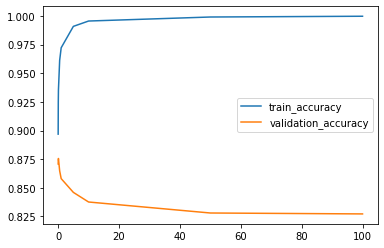

In [51]:
plt.plot(log_bow_df['C'], log_bow_df['train_acc'], label='train_accuracy')
plt.plot(log_bow_df['C'], log_bow_df['validation_acc'], label='validation_accuracy')
plt.legend()

In [52]:
log_bow_df.sort_values(ascending=False, by=['validation_acc'])

,C,train_acc,validation_acc
2,0.10,0.935378,0.8756
1,0.05,0.924711,0.8740
0,0.01,0.896844,0.8708
3,0.50,0.961244,0.8648
4,1.00,0.972267,0.8580
5,5.00,0.990933,0.8460
6,10.00,0.995600,0.8376
7,50.00,0.999111,0.8280
8,100.00,0.999778,0.8272


In [53]:
log_tf = log_C_optmizer(X_train_tf, y_train, X_validation_tf, y_validation)

  0%|          | 0/9 [00:00<?, ?it/s]

In [54]:
log_tf_df = pd.DataFrame(log_tf, columns=['C', 'train_acc', 'validation_acc'])
log_tf_df

,C,train_acc,validation_acc
0,0.01,0.831600,0.8240
1,0.05,0.860667,0.8476
2,0.10,0.872756,0.8588
3,0.50,0.901200,0.8756
4,1.00,0.911911,0.8820
5,5.00,0.940533,0.8816
6,10.00,0.953067,0.8820
7,50.00,0.977378,0.8576
8,100.00,0.986489,0.8508


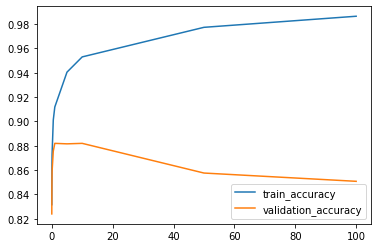

In [55]:
plt.plot(log_tf_df['C'], log_tf_df['train_acc'], label='train_accuracy')
plt.plot(log_tf_df['C'], log_tf_df['validation_acc'], label='validation_accuracy')
plt.legend()

In [56]:
log_tf_df.sort_values(ascending=False, by=['validation_acc'])

,C,train_acc,validation_acc
4,1.00,0.911911,0.8820
6,10.00,0.953067,0.8820
5,5.00,0.940533,0.8816
3,0.50,0.901200,0.8756
2,0.10,0.872756,0.8588
7,50.00,0.977378,0.8576
8,100.00,0.986489,0.8508
1,0.05,0.860667,0.8476
0,0.01,0.831600,0.8240


>> # Fitting with tuned hyperparameters

In [142]:
def log_final(train, y_train, test, y_test, C=0.0):
    lr = LogisticRegression(max_iter=1000, solver='liblinear', C=C, random_state=210)
    lr.fit(train, y_train)
    y_prediction_train = lr.predict_proba(train)[:, 1]
    y_prediction_test = lr.predict_proba(test)[:,1]
    train_acc = accuracy_score(y_train, y_prediction_train >= 0.5)
    test_acc = accuracy_score(y_test, y_prediction_test >= 0.5)
    return {'train_acc': train_acc,  'test_acc': test_acc}

In [143]:
log_final(X_full_train_bow, y_full_train, X_test_bow, y_test, 0.10)

{'train_acc': 0.96152, 'test_acc': 0.87812}

In [144]:
log_final(X_full_train_tf, y_full_train, X_test_tf, y_test, 1.0)

{'train_acc': 0.9234, 'test_acc': 0.88468}

> # Random Forest
>> # Quick proto type

In [230]:
def rf_proto(train, y_train, test, y_test):
    rf = RandomForestClassifier()
    rf.fit(train, y_train)
    y_prediction_train = rf.predict_proba(train)[:, 1]
    y_predicted_test = rf.predict_proba(test)[:,1]
    train_acc = accuracy_score(y_train, (y_prediction_train >= 0.5))
    test_acc = accuracy_score(y_test, (y_predicted_test >= 0.5))
    return {'train_acc': train_acc, 'test_acc': test_acc}

In [196]:
rf_proto(X_train_bow, y_train, X_validation_bow, y_validation)

{'train_acc': 1.0, 'validation_acc': 0.8408}

In [197]:
rf_proto(X_train_tf, y_train, X_validation_tf, y_validation)

{'train_acc': 1.0, 'validation_acc': 0.8292}

> really good accuracy compared to the previous classifiers, But still overfitting as the model is really complex so it stores the pattern itself not learning the pattern of the data.

>> # Parameter Tunning

In [75]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
}

In [79]:
rfc = RandomForestClassifier(random_state=1999)
rfc_random = RandomizedSearchCV(estimator = rfc, 
                                param_distributions = random_grid, 
                                n_iter = 10,
                                scoring = 'accuracy',
                                cv = 4, 
                                verbose=2, 
                                random_state=1999)

# Fit the random search model
rfc_random.fit(X_full_train_bow, y_full_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 1.7min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 1.7min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 1.7min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 1.7min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 3.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 3.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=1999),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1999, scoring='accuracy', verbose=2)

In [81]:
print('Best Accuracy: %.5f' %rfc_random.best_score_)
print('Best Parameters: ', rfc_random.best_params_)

Best Accuracy: 0.84852
Best Parameters:  {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


In [82]:
rfc2 = RandomForestClassifier(random_state=1999)
rfc_random2 = RandomizedSearchCV(estimator = rfc2, 
                                param_distributions = random_grid, 
                                n_iter = 10,
                                scoring = 'accuracy',
                                cv = 4, 
                                verbose=2, 
                                random_state=1999)

# Fit the random search model
rfc_random2.fit(X_full_train_tf, y_full_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 2.2min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 2.2min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 2.2min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 4.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 4.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=1999),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1999, scoring='accuracy', verbose=2)

In [84]:
print('Best Accuracy: %.5f' %rfc_random2.best_score_)
print('Best Parameters: ', rfc_random2.best_params_)

Best Accuracy: 0.84772
Best Parameters:  {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


>> # Fitting with the best parameters

In [86]:
def rf_final(train, y_train, test, y_test):
    rf = RandomForestClassifier(n_estimators= 600, min_samples_split= 10, min_samples_leaf=1, 
             max_features= 'sqrt', max_depth= 60, bootstrap= False)
    rf.fit(train, y_train)
    y_prediction_train = rf.predict_proba(train)[:, 1]
    y_predicted_test = rf.predict_proba(test)[:,1]
    train_acc = accuracy_score(y_train, (y_prediction_train >= 0.5))
    test_acc = accuracy_score(y_test, (y_predicted_test >= 0.5))
    return {'train_acc': train_acc, 'validation_acc': test_acc}

In [87]:
rf_final(X_full_train_bow, y_full_train, X_test_bow, y_test)

{'train_acc': 0.99608, 'validation_acc': 0.8536}

In [88]:
rf_final(X_full_train_tf, y_full_train, X_test_tf, y_test)

{'train_acc': 0.9986, 'validation_acc': 0.852}

> # linear SVM

In [198]:
# standerizing the data for SVM usage using MaxAbsScaler which make standerize each feature indevidually to max value 1.0

std_bow = MaxAbsScaler().fit(X_train_bow)
standerized_validation_bow = std_bow.transform(X_validation_bow)
standerized_train_bow = std_bow.transform(X_train_bow)

std_tf = MaxAbsScaler().fit(X_train_tf)
standerized_validation_tf = std_tf.transform(X_validation_tf)
standerized_train_tf = std_tf.transform(X_train_tf)

std_bow = MaxAbsScaler().fit(X_full_train_bow)
standerized_test_bow = std_bow.transform(X_test_bow)
standerized_full_train_bow = std_bow.transform(X_full_train_bow)

std_tf = MaxAbsScaler().fit(X_full_train_tf)
standerized_test_tf = std_tf.transform(X_test_tf)
standerized_full_train_tf = std_tf.transform(X_full_train_tf)

>> # Quick protoType

In [229]:
def _svm(train, y_train, test, y_test, C=1.0):
    svm = LinearSVC(max_iter=10000, C=C)
    svm.fit(train, y_train)
    y_prediction_train = svm.predict(train)
    y_predicted_test = svm.predict(test)
    train_acc = accuracy_score(y_train, (y_prediction_train >= 0.5))
    test_acc = accuracy_score(y_test, (y_predicted_test >= 0.5))
    return {'train_acc': train_acc, 'test_acc': test_acc}

In [200]:
_svm(standerized_train_bow, y_train, standerized_validation_bow, y_validation)

{'train_acc': 0.9744444444444444, 'test_acc': 0.8528}

In [201]:
_svm(standerized_train_tf, y_train, standerized_validation_tf, y_validation)

{'train_acc': 0.9815111111111111, 'test_acc': 0.844}

>> # Parameter Tunning

In [ ]:
C = np.linspace(0.001, 1, 99)

def svm_optmizer(train, y_train, test, y_test):
    accs = []
    for c in C:
        acc = _svm(train, y_train, test, y_test, C=c)
        accs.append((c, acc['train_acc'], acc['test_acc']))
    return accs

In [ ]:
bow_scores = svm_optmizer(standerized_train_bow, y_train, standerized_validation_bow, y_validation)

In [ ]:
tf_scores = svm_optmizer(standerized_train_tf, y_train, standerized_validation_tf, y_validation)

In [ ]:
bow_scores_df = pd.DataFrame(bow_scores, columns=['C', 'train_acc', 'test_acc'])
bow_scores_df

In [ ]:
plt.plot(bow_scores_df.C, bow_scores_df.train_acc, label='train')
plt.plot(bow_scores_df.C, bow_scores_df.test_acc, label='train')

In [ ]:
bow_scores_df.sort_values(ascending=False, by=['test_acc'])[:3]

In [ ]:
tf_scores_df = pd.DataFrame(tf_scores, columns=['C', 'train_acc', 'test_acc'])
tf_scores_df

In [ ]:
plt.plot(tf_scores_df.C, tf_scores_df.train_acc, label='train')
plt.plot(tf_scores_df.C, tf_scores_df.test_acc, label='train')

In [ ]:
tf_scores_df.sort_values(ascending=False, by=['test_acc'])[:3]

>> # Fitting with best parameters

In [ ]:
_svm(standerized_full_train_bow, y_full_train, standerized_test_bow, y_test, C=0.051969)

In [ ]:
_svm(standerized_full_train_tf, y_full_train, standerized_test_tf, y_test, C=0.041776)

> # Non Linear SVM

>> # Quick prototype

In [228]:
def _NLsvm(train, y_train, test, y_test, C=1.0):
    svm = SVC(max_iter=10000, C=C)
    svm.fit(train, y_train)
    y_prediction_train = svm.predict(train)
    y_predicted_test = svm.predict(test)
    train_acc = accuracy_score(y_train, (y_prediction_train >= 0.5))
    test_acc = accuracy_score(y_test, (y_predicted_test >= 0.5))
    return {'train_acc': train_acc, 'test_acc': test_acc}

In [203]:
_NLsvm(standerized_train_bow, y_train, standerized_validation_bow, y_validation)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


{'train_acc': 0.9649777777777778, 'test_acc': 0.8692}

In [204]:
_NLsvm(standerized_train_tf, y_train, standerized_validation_tf, y_validation)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


{'train_acc': 0.9842222222222222, 'test_acc': 0.882}

>> # final Testing

In [ ]:
_NLsvm(standerized_full_train_bow, y_full_train, standerized_test_bow, y_test)

In [ ]:
_NLsvm(standerized_full_train_tf, y_full_train, standerized_test_tf, y_test)

> # Boosting
>> # Quick proto type

In [205]:
dtrain_tf = xgb.DMatrix(data=X_train_tf, label=y_train)
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
    'eval_metric': 'auc'
}

xdg_tf = xgb.train(xgb_params, dtrain_tf, num_boost_round=100)

In [206]:
y_predicted_train_tf = xdg_tf.predict(dtrain_tf)

In [207]:
accuracy_score(y_train, (y_predicted_train_tf >= 0.5))

0.7680888888888889

In [208]:
dvalidation_tf = xgb.DMatrix(data=X_validation_tf, label=y_validation)

In [209]:
y_predicted_validate_tf = xdg_tf.predict(dvalidation_tf)

In [210]:
accuracy_score(y_validation, (y_predicted_validate_tf >= 0.5))

0.7456

>> # final test

In [95]:
dtrain_tf = xgb.DMatrix(data=X_full_train_tf, label=y_full_train)
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
    'eval_metric': 'auc'
}

xdg_tf = xgb.train(xgb_params, dtrain_tf, num_boost_round=100)

In [96]:
y_predicted_train_tf = xdg_tf.predict(dtrain_tf)

In [98]:
accuracy_score(y_full_train, (y_predicted_train_tf >= 0.5))

0.76376

In [99]:
dtest_tf = xgb.DMatrix(data=X_test_tf, label=y_test)

In [100]:
y_predicted_test_tf = xdg_tf.predict(dtest_tf)

In [102]:
accuracy_score(y_test, (y_predicted_test_tf >= 0.5))

0.75128

# Feature number effect

In [226]:
functions = {
    'knn': KNN_proto, 
    'naive bayes': Naive_proto,
    'logistic regression': log_proto, 
    'Linear SVM': _svm, 
    'non Linear SVM': _NLsvm, 
    'Random Forest': rf_proto
}

In [236]:
def feature_based_Accs():
    collected_data = []
    for feature_no in tqdm([i for i in range(4000, 26000, 2000)]):
        tf = TfidfVectorizer(max_features=feature_no).fit(X_train)
        X_train_tf = tf.transform(X_train)
        X_validation_tf = tf.transform(X_validation)
        
        for algo_name, algo in tqdm(functions.items()):
            result = algo(X_train_tf, y_train, X_validation_tf, y_validation)
            collected_data.append((feature_no, algo_name, result['train_acc'], result['test_acc']))
    return collected_data

In [237]:
feature_based_Accs()

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[(4000, 'knn', 0.8676888888888888, 0.746),
 (4000, 'naive bayes', 0.8656888888888888, 0.8528),
 (4000, 'logistic regression', 0.906, 0.876),
 (4000, 'Linear SVM', 0.9302666666666667, 0.8684),
 (4000, 'non Linear SVM', 0.9804444444444445, 0.8808),
 (4000, 'Random Forest', 1.0, 0.8328),
 (6000, 'knn', 0.8692, 0.7484),
 (6000, 'naive bayes', 0.8718666666666667, 0.8648),
 (6000, 'logistic regression', 0.9108, 0.8804),
 (6000, 'Linear SVM', 0.9487111111111111, 0.8796),
 (6000, 'non Linear SVM', 0.9831555555555556, 0.886),
 (6000, 'Random Forest', 1.0, 0.8356),
 (8000, 'knn', 0.8708444444444444, 0.7592),
 (8000, 'naive bayes', 0.8778222222222222, 0.8672),
 (8000, 'logistic regression', 0.9140888888888888, 0.882),
 (8000, 'Linear SVM', 0.9579111111111112, 0.8788),
 (8000, 'non Linear SVM', 0.9841333333333333, 0.8856),
 (8000, 'Random Forest', 1.0, 0.8348),
 (10000, 'knn', 0.8713333333333333, 0.7516),
 (10000, 'naive bayes', 0.8818666666666667, 0.8684),
 (10000, 'logistic regression', 0.915555

In [238]:
collected_data = [(4000, 'knn', 0.8676888888888888, 0.746),
 (4000, 'naive bayes', 0.8656888888888888, 0.8528),
 (4000, 'logistic regression', 0.906, 0.876),
 (4000, 'Linear SVM', 0.9302666666666667, 0.8684),
 (4000, 'non Linear SVM', 0.9804444444444445, 0.8808),
 (4000, 'Random Forest', 1.0, 0.8328),
 (6000, 'knn', 0.8692, 0.7484),
 (6000, 'naive bayes', 0.8718666666666667, 0.8648),
 (6000, 'logistic regression', 0.9108, 0.8804),
 (6000, 'Linear SVM', 0.9487111111111111, 0.8796),
 (6000, 'non Linear SVM', 0.9831555555555556, 0.886),
 (6000, 'Random Forest', 1.0, 0.8356),
 (8000, 'knn', 0.8708444444444444, 0.7592),
 (8000, 'naive bayes', 0.8778222222222222, 0.8672),
 (8000, 'logistic regression', 0.9140888888888888, 0.882),
 (8000, 'Linear SVM', 0.9579111111111112, 0.8788),
 (8000, 'non Linear SVM', 0.9841333333333333, 0.8856),
 (8000, 'Random Forest', 1.0, 0.8348),
 (10000, 'knn', 0.8713333333333333, 0.7516),
 (10000, 'naive bayes', 0.8818666666666667, 0.8684),
 (10000, 'logistic regression', 0.9155555555555556, 0.8824),
 (10000, 'Linear SVM', 0.9629333333333333, 0.8808),
 (10000, 'non Linear SVM', 0.9846666666666667, 0.8888),
 (10000, 'Random Forest', 1.0, 0.8376),
 (12000, 'knn', 0.8709777777777777, 0.7552),
 (12000, 'naive bayes', 0.8847555555555555, 0.8692),
 (12000, 'logistic regression', 0.9162666666666667, 0.8824),
 (12000, 'Linear SVM', 0.9653777777777778, 0.878),
 (12000, 'non Linear SVM', 0.9849777777777777, 0.8888),
 (12000, 'Random Forest', 1.0, 0.8304),
 (14000, 'knn', 0.8724444444444445, 0.754),
 (14000, 'naive bayes', 0.8866222222222222, 0.8692),
 (14000, 'logistic regression', 0.9167111111111111, 0.882),
 (14000, 'Linear SVM', 0.9678666666666667, 0.8768),
 (14000, 'non Linear SVM', 0.9855111111111111, 0.8892),
 (14000, 'Random Forest', 1.0, 0.8396),
 (16000, 'knn', 0.8718222222222223, 0.7524),
 (16000, 'naive bayes', 0.8879555555555556, 0.868),
 (16000, 'logistic regression', 0.9172, 0.8816),
 (16000, 'Linear SVM', 0.9694666666666667, 0.8768),
 (16000, 'non Linear SVM', 0.9855555555555555, 0.8888),
 (16000, 'Random Forest', 1.0, 0.8396),
 (18000, 'knn', 0.8718222222222223, 0.7516),
 (18000, 'naive bayes', 0.8892, 0.8688),
 (18000, 'logistic regression', 0.9178666666666667, 0.8812),
 (18000, 'Linear SVM', 0.9706666666666667, 0.8784),
 (18000, 'non Linear SVM', 0.9859555555555556, 0.8884),
 (18000, 'Random Forest', 1.0, 0.8396),
 (20000, 'knn', 0.8714666666666666, 0.7528),
 (20000, 'naive bayes', 0.8897777777777778, 0.868),
 (20000, 'logistic regression', 0.9179555555555555, 0.8808),
 (20000, 'Linear SVM', 0.9712444444444445, 0.8796),
 (20000, 'non Linear SVM', 0.9858222222222223, 0.8884),
 (20000, 'Random Forest', 1.0, 0.8432),
 (22000, 'knn', 0.8715555555555555, 0.7524),
 (22000, 'naive bayes', 0.8903111111111112, 0.8676),
 (22000, 'logistic regression', 0.9181777777777778, 0.8812),
 (22000, 'Linear SVM', 0.9712444444444445, 0.8804),
 (22000, 'non Linear SVM', 0.9856888888888888, 0.8884),
 (22000, 'Random Forest', 1.0, 0.836),
 (24000, 'knn', 0.8717333333333334, 0.7528),
 (24000, 'naive bayes', 0.8908, 0.8676),
 (24000, 'logistic regression', 0.9181333333333334, 0.8816),
 (24000, 'Linear SVM', 0.9713333333333334, 0.8796),
 (24000, 'non Linear SVM', 0.9858666666666667, 0.8888),
 (24000, 'Random Forest', 1.0, 0.8392)]

In [240]:
df = pd.DataFrame(collected_data, columns=['feature_no', 'algo_name', 'train_acc', 'test_acc'])
df

,feature_no,algo_name,train_acc,test_acc
0,4000,knn,0.867689,0.7460
1,4000,naive bayes,0.865689,0.8528
2,4000,logistic regression,0.906000,0.8760
3,4000,Linear SVM,0.930267,0.8684
4,4000,non Linear SVM,0.980444,0.8808
...,...,...,...,...
61,24000,naive bayes,0.890800,0.8676
62,24000,logistic regression,0.918133,0.8816
63,24000,Linear SVM,0.971333,0.8796
64,24000,non Linear SVM,0.985867,0.8888


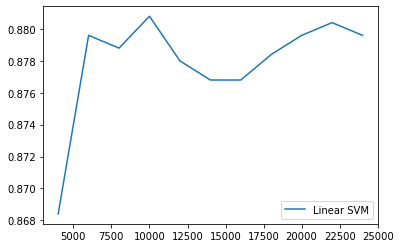

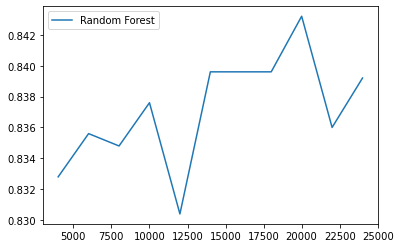

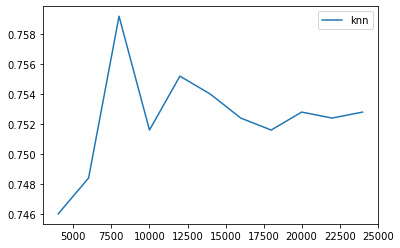

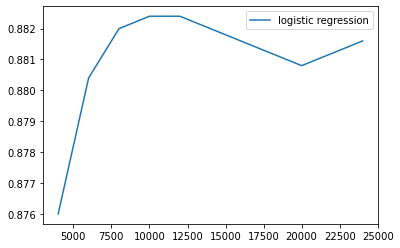

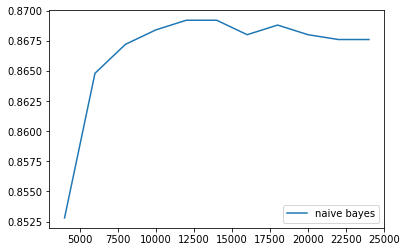

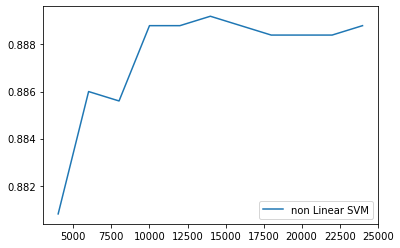

In [245]:
for algo_name, group in df.groupby('algo_name'):
    plt.plot(group['feature_no'], group['test_acc'], label=algo_name)
    plt.legend()
    plt.show()